In [1]:
import numpy as np
import scipy
import scipy.io
import scipy.signal
import matplotlib as mpl
import matplotlib.pyplot as plt

####################################
# apply some settings for plotting #
####################################
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['xtick.labelsize'] = 7
mpl.rcParams['ytick.labelsize'] = 7
mpl.rcParams['axes.titlesize'] = 9
cmap = 'plasma'
color1 = '#e66101'.upper()
color2 = '#5e3c99'.upper()
blind_ax = dict(top=False, bottom=False, left=False, right=False,
        labelleft=False, labelright=False, labeltop=False,
        labelbottom=False)

In [2]:
def calc_csd(x, nperseg, fs=1.0, axis=-1, **kwargs):
    """Calculate the cross-spectral density (csd) of a 2d signal
    Welch's average periodogram technique is used

    Args:
        x (ndarray): a 2d numpy array whose csd is to be calculated
        nperseg (int): the number of datapoints in every segment,
            determines the frequency resolution
        fs (float): the sampling rate
        axis (int): the axis along which the Fourier transform is
            calculated. Defaults to the last axis
        **kwargs: Keyword arguments, as in scipy.signal.welch

    Returns:
        f (ndarray): frequencies corresponding to the result array
        csd (2d ndarray): cross-spectral density of x. The shape will be
            (x.shape[-1-axis], x.shape[-1-axis], len(f))
    """
    if x.ndim != 2:
        raise ValueError('x must be a 2d ndarray')
    if axis != -1:
        x = np.rollaxis(x, axis, len(x.shape))
    idx1, idx2 = np.indices([x.shape[0], x.shape[0]])
    f, csd = scipy.signal.csd(x[idx1], x[idx2], fs=fs,
            nperseg=nperseg, axis=axis, **kwargs)
    return f, csd

def calc_coherence(csd):
    """Calculate the coherence from a csd-mactrix

    Args:
        csd (complex ndarray): matrix of cross-spectral density matrices

    Returns:
        coherence (ndarray): complex valued coherence matrix
    """
    if not csd.shape[0] == csd.shape[1]:
        raise ValueError('csd must be square in the first 2 dimensions')
    ch = csd.shape[0]
    return csd/np.sqrt(csd[range(ch), range(ch),np.newaxis]*
            csd[np.newaxis, range(ch), range(ch)])


In [3]:
#################
# read the data #
#################
f_on_data = '../../data/raw/rest/subj1/on/subj1_on_R7.mat'
f_off_data = '../../data/raw/rest/subj1/off/subj1_off_R7.mat'

on_data = scipy.io.loadmat(f_on_data)['data'][0,0][1][0,0]
on_labels = [i[0][0] for i in scipy.io.loadmat(f_on_data)['data'][0,0][0]]
on_t = scipy.io.loadmat(f_on_data)['data'][0,0][2][0,0][0]

off_data = scipy.io.loadmat(f_off_data)['data'][0,0][1][0,0]
off_labels = [i[0][0] for i in scipy.io.loadmat(f_off_data)['data'][0,0][0]]
off_t = scipy.io.loadmat(f_off_data)['data'][0,0][2][0,0][0]

if np.allclose(np.diff(on_t), np.diff(on_t)[0]):
    on_d = np.diff(on_t)[0]
    on_s_rate = 1./on_d
else:
    raise ValueError('Signal must be evenly sampled')

if np.allclose(np.diff(off_t), np.diff(off_t)[0]):
    off_d = np.diff(off_t)[0]
    off_s_rate = 1./off_d
else:
    raise ValueError('Signal must be evenly sampled')

if not on_labels == off_labels:
    raise ValueError('channel labels must be equal during on and off')


# Average = "mean"

In [4]:
####################################
# calculate spectrum and coherence #
####################################
on_f, on_csd = calc_csd(on_data, fs=on_s_rate, nperseg=2*int(on_s_rate), average="mean",
        axis=-1)
on_coherence = calc_coherence(on_csd)
off_f, off_csd = calc_csd(off_data, fs=off_s_rate, nperseg=2*int(off_s_rate), average="mean",
        axis=-1)
off_coherence = calc_coherence(off_csd)

In [6]:
n_ch = 9 # plot only the first 9 channels
plot_f = 45 # frequency until which the signal is plotted

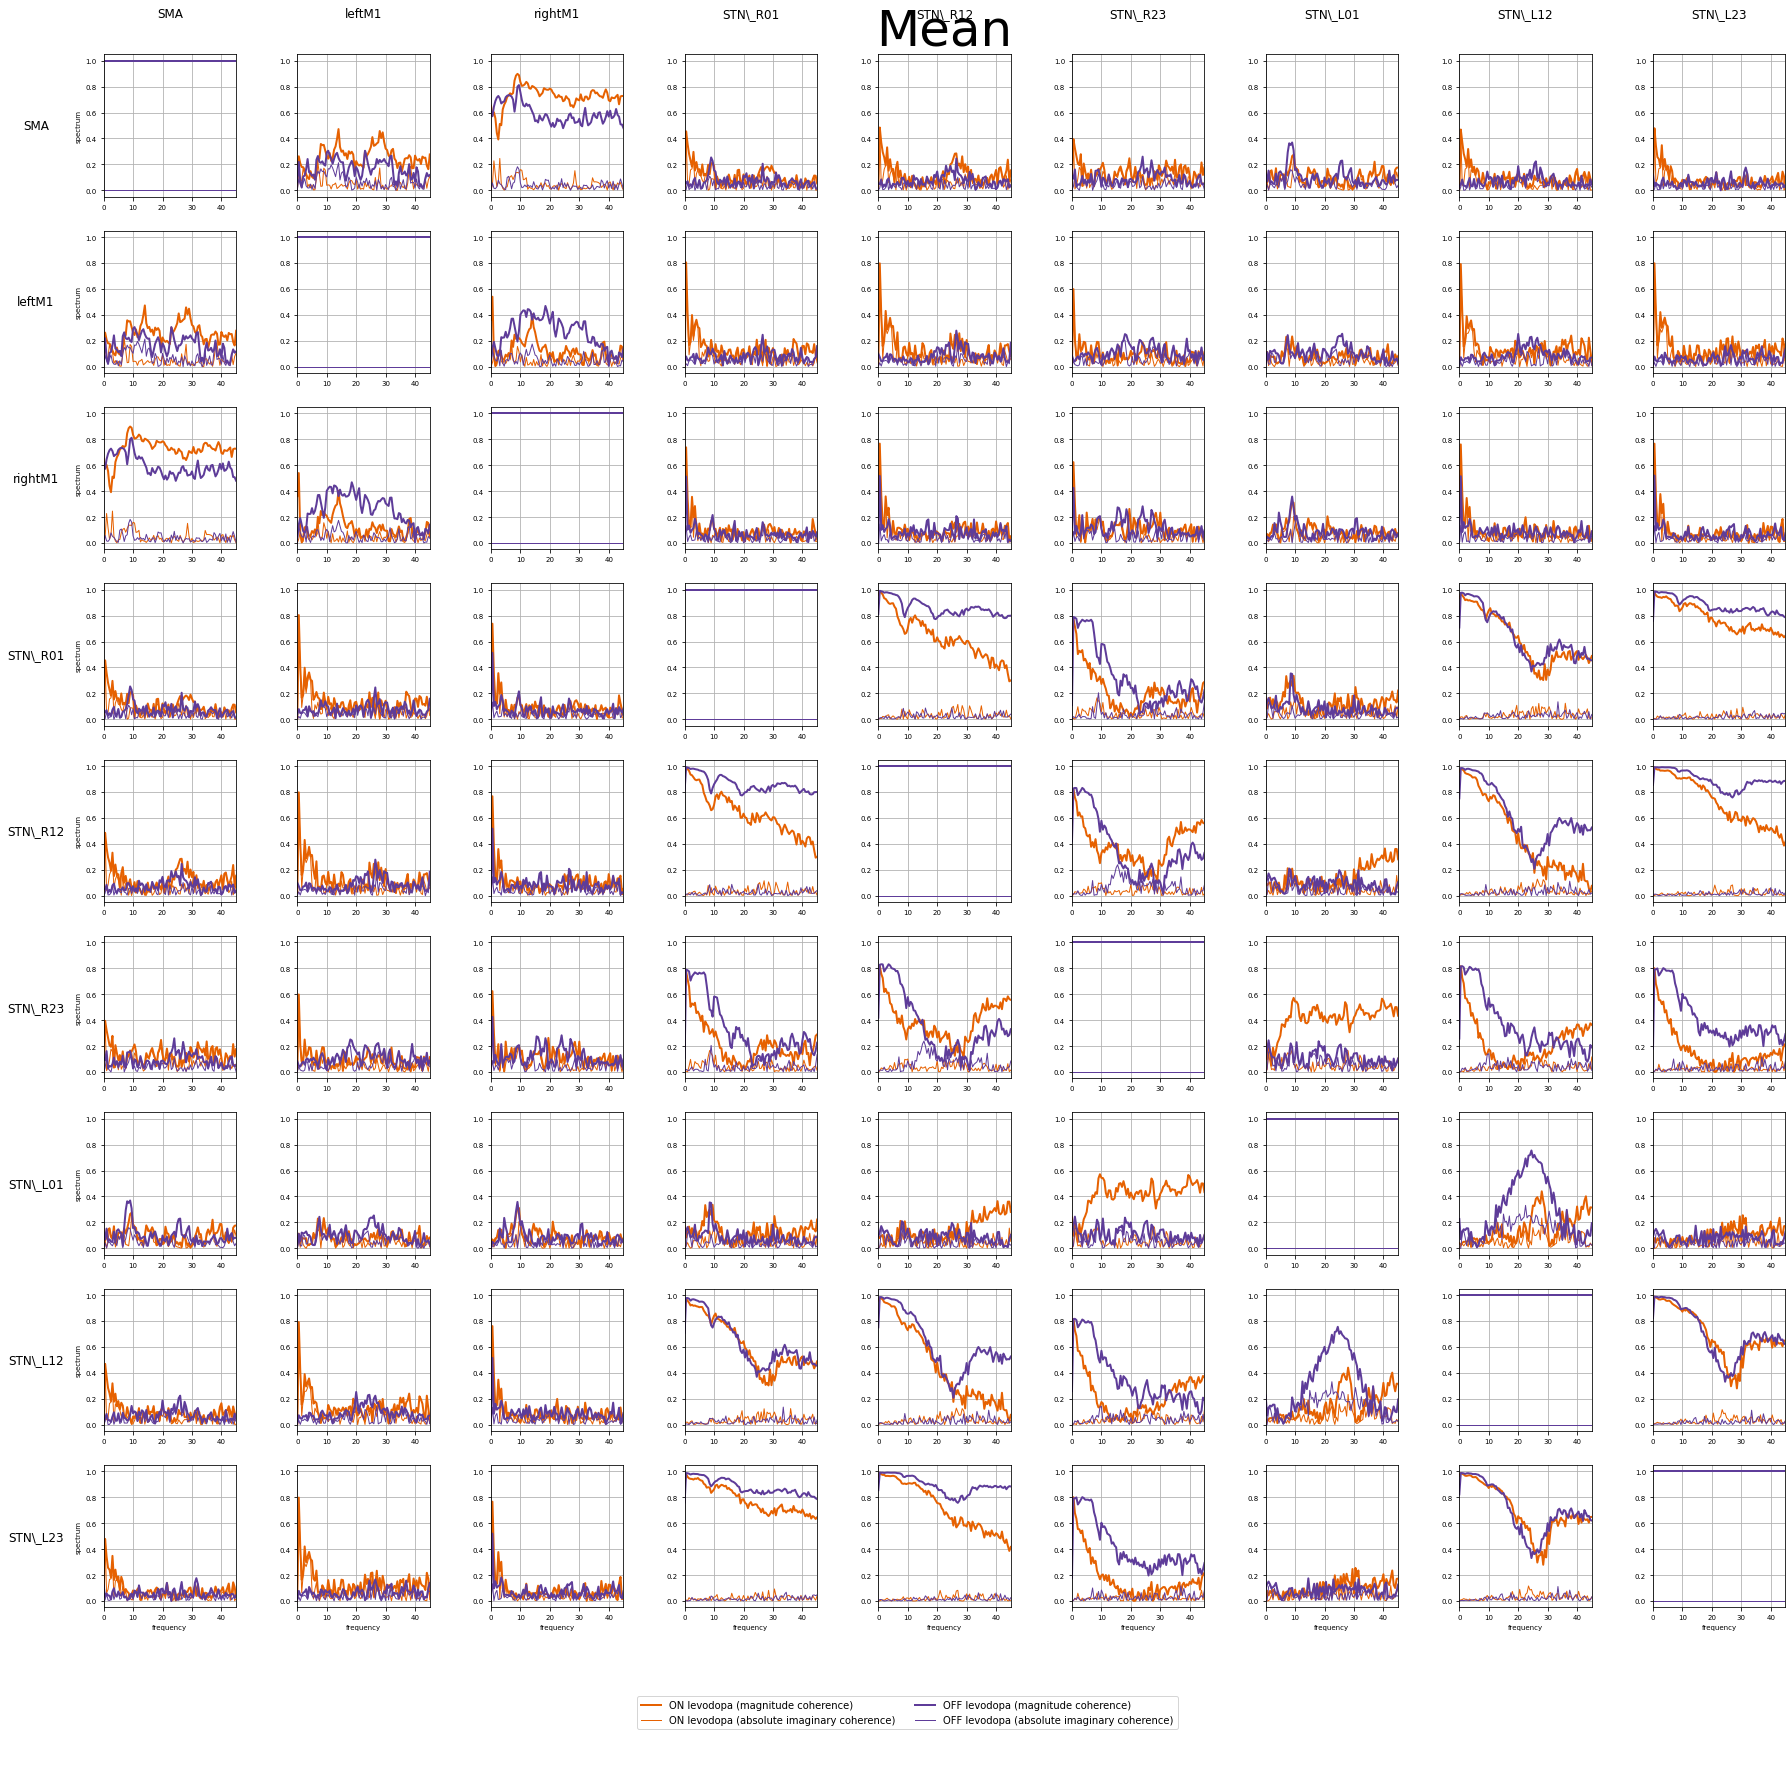

In [7]:
###################################
# plot the power spectral density #
###################################
csd_fig = plt.figure(figsize=(25, 25))
csd_gs = mpl.gridspec.GridSpec(n_ch + 2, n_ch + 1,
        width_ratios=np.r_[0.1, [1]*n_ch],
        height_ratios = np.r_[0.1, [1]*(n_ch + 1)])
csd_axes = np.zeros([n_ch, n_ch], dtype=np.object)
csd_text_axes = np.zeros([n_ch, 2], dtype=np.object)
csd_lines = np.zeros((n_ch, n_ch, 4), dtype=np.object)
for i in range(n_ch):
    for j in range(n_ch):
        if (i == 0) & (j == 0):
            csd_axes[i,j] = csd_fig.add_subplot(csd_gs[i + 1, j + 1])
        else:
            csd_axes[i,j] = csd_fig.add_subplot(csd_gs[i + 1, j + 1],
                    sharex=csd_axes[0,0], sharey=csd_axes[0,0])
        csd_axes[i,j].grid()
        csd_lines[i,j,0], = csd_axes[i,j].plot(on_f[on_f<=plot_f], np.abs(
            on_coherence[i,j,on_f<=plot_f]), color=color1, ls='-', lw=2)
        csd_lines[i,j,1], = csd_axes[i,j].plot(on_f[on_f<=plot_f], np.abs(
            on_coherence[i,j,on_f<=plot_f].imag), color=color1, ls='-', lw=1)
        csd_lines[i,j,2], = csd_axes[i,j].plot(off_f[off_f<=plot_f], np.abs(
            off_coherence[i,j,off_f<=plot_f]), color=color2, ls='-', lw=2)
        csd_lines[i,j,3], = csd_axes[i,j].plot(off_f[off_f<=plot_f], np.abs(
            off_coherence[i,j,off_f<=plot_f].imag), color=color2, ls='-', lw=1)
        if i == 0:
            csd_text_axes[j,0] = csd_fig.add_subplot(csd_gs[i,j + 1], frameon=False)
            csd_text_axes[j,0].tick_params(**blind_ax)
            csd_text_axes[j,0].text(0.5,0.5, s=on_labels[j].replace('_', '\_'),
                    ha='center', va='center', fontsize=12)
        if i == n_ch - 1:
            csd_axes[i,j].set_xlabel('frequency')
        if j == 0:
            csd_axes[i,j].set_ylabel('spectrum')
            csd_text_axes[i,1] = csd_fig.add_subplot(csd_gs[i + 1,j], frameon=False)
            csd_text_axes[i,1].tick_params(**blind_ax)
            csd_text_axes[i,1].text(0.5,0.5, s=on_labels[i].replace('_', '\_'),
                    ha='center', va='center', fontsize=12)

csd_axes[0,0].set_xlim([0,plot_f])
#csd_axes[0,0].set_ylim([0,1])

# add a dummy axis for the legend
csd_legend_ax = csd_fig.add_subplot(csd_gs[-1,:], frame_on=False)
csd_legend_ax.tick_params(**blind_ax)
csd_legend_ax.legend(
        (csd_lines[0,0,0], csd_lines[0,0,1], csd_lines[0,0,2], csd_lines[0,0,3]),
        ('ON levodopa (magnitude coherence)',
            'ON levodopa (absolute imaginary coherence)',
            'OFF levodopa (magnitude coherence)',
            'OFF levodopa (absolute imaginary coherence)'),
        loc='center', ncol=2)

csd_fig.tight_layout()
csd_axes[0, 4].set_title("Mean", fontsize=50)
plt.show()
#csd_fig.savefig('subj1_csd.pdf')


# Average = "median"

In [8]:
####################################
# calculate spectrum and coherence #
####################################
on_f_med, on_csd_med = calc_csd(on_data, fs=on_s_rate, nperseg=2*int(on_s_rate), average="median",
        axis=-1)
on_coherence_med = calc_coherence(on_csd_med)
off_f_med, off_csd_med = calc_csd(off_data, fs=off_s_rate, nperseg=2*int(off_s_rate), average="median",
        axis=-1)
off_coherence_med = calc_coherence(off_csd_med)

<ipython-input-2-5d79f7c13520>:40: RuntimeWarning: invalid value encountered in true_divide
  return csd/np.sqrt(csd[range(ch), range(ch),np.newaxis]*


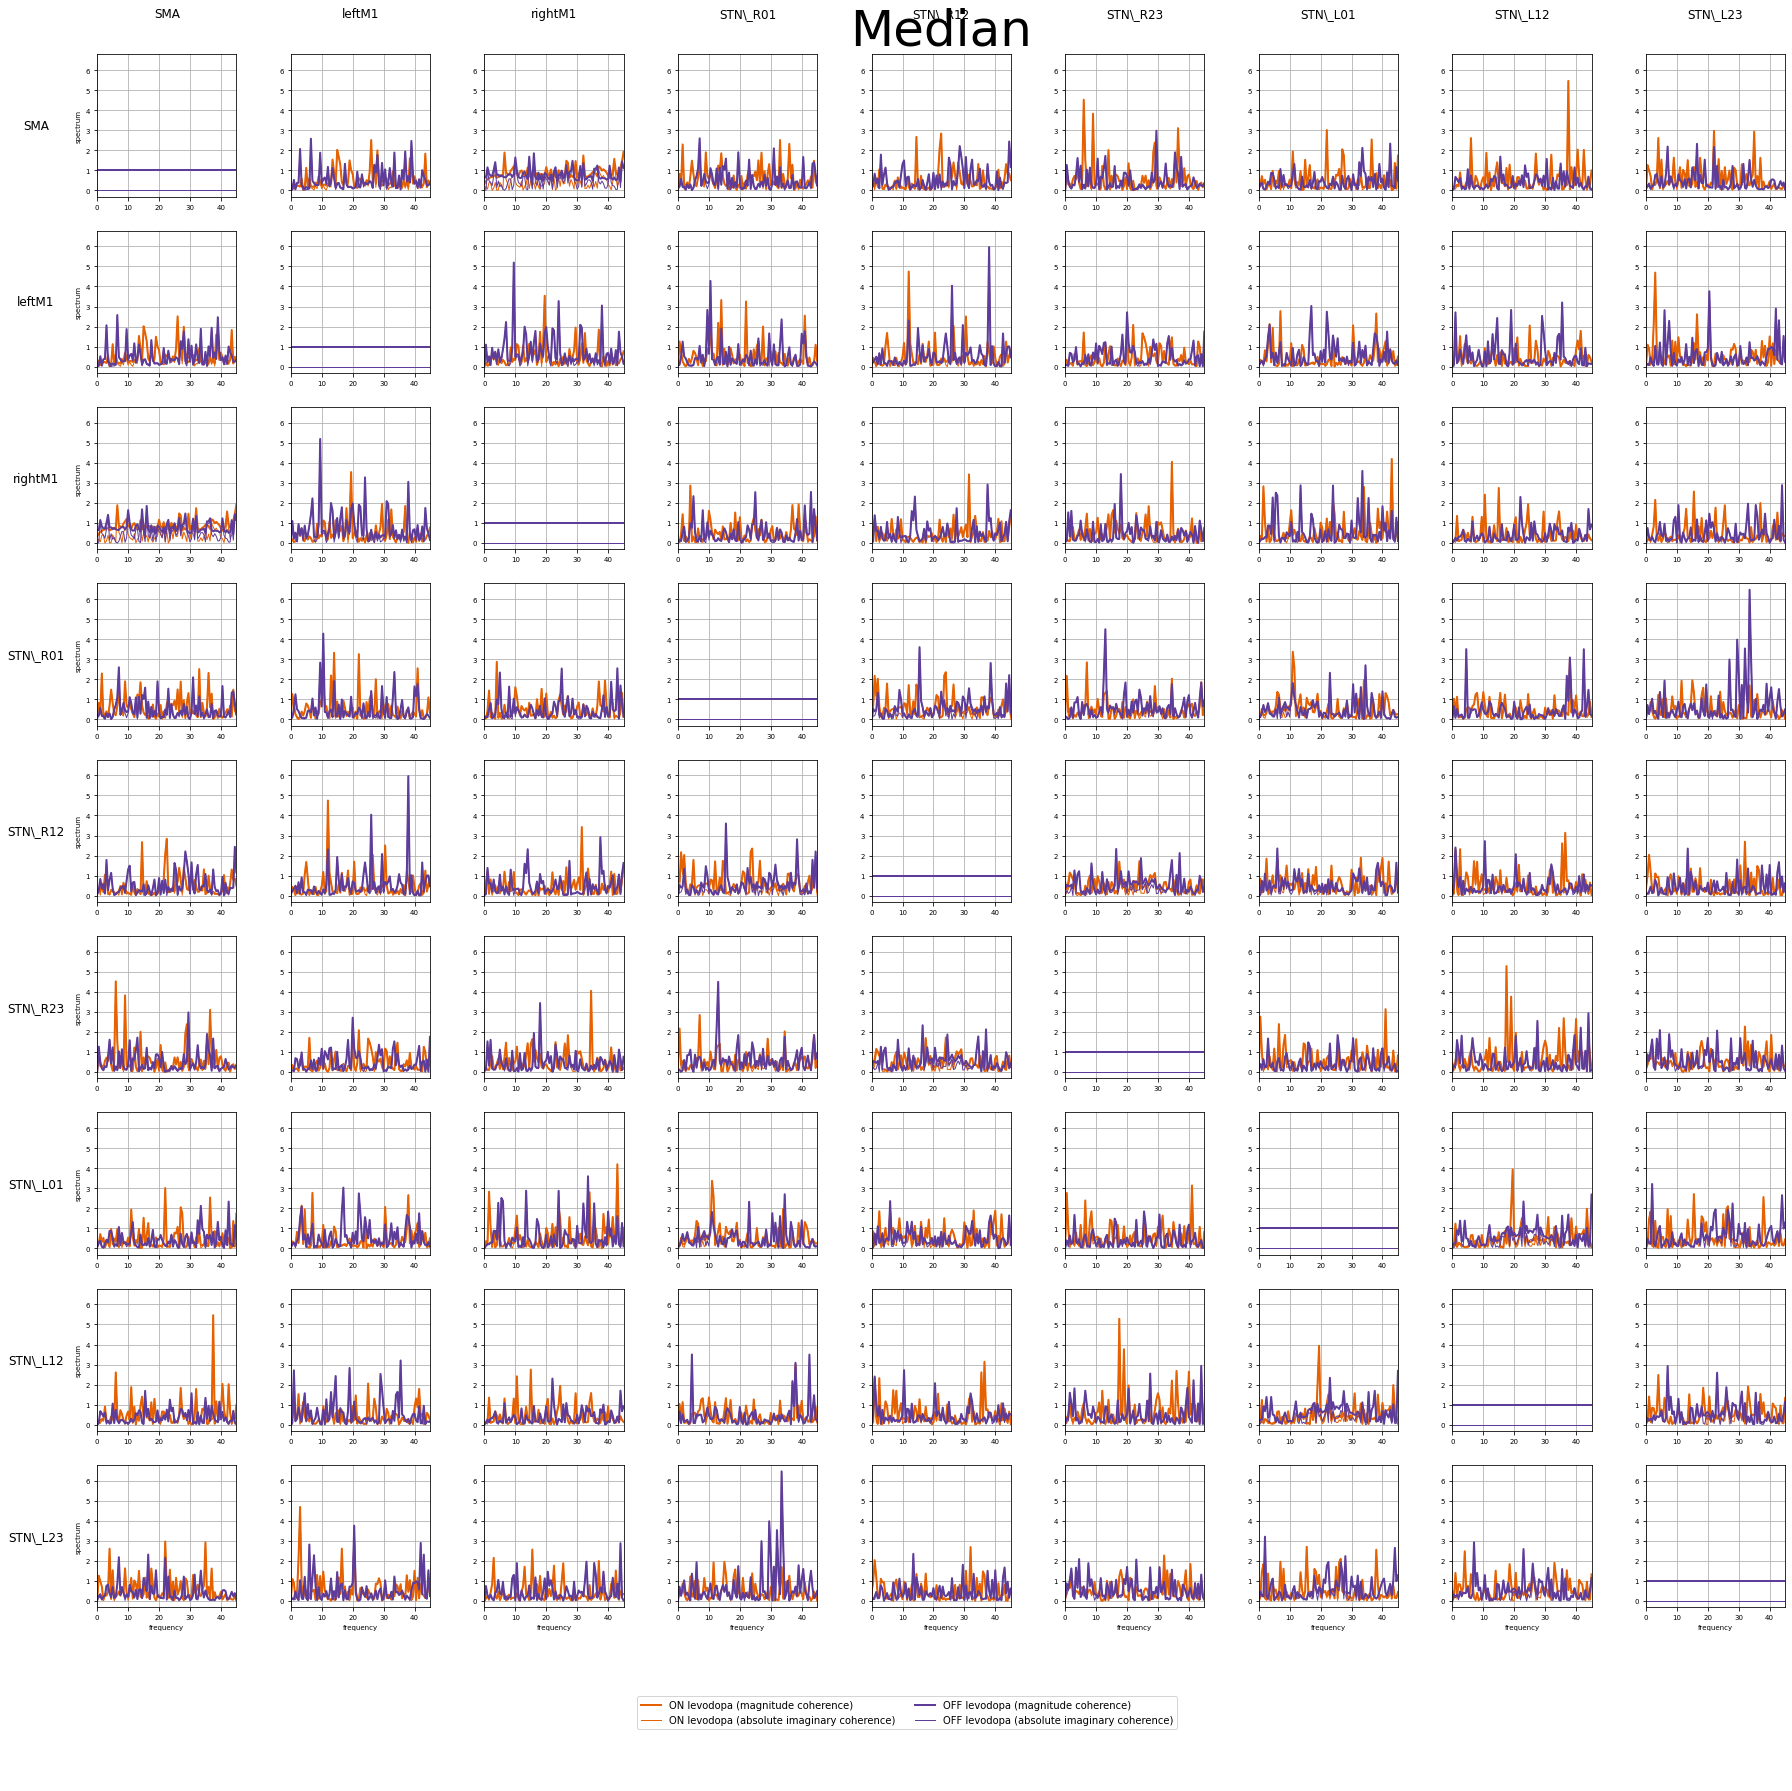

In [9]:
###################################
# plot the power spectral density #
###################################
csd_fig = plt.figure(figsize=(25, 25))
csd_gs = mpl.gridspec.GridSpec(n_ch + 2, n_ch + 1,
        width_ratios=np.r_[0.1, [1]*n_ch],
        height_ratios = np.r_[0.1, [1]*(n_ch + 1)])
csd_axes = np.zeros([n_ch, n_ch], dtype=np.object)
csd_text_axes = np.zeros([n_ch, 2], dtype=np.object)
csd_lines = np.zeros((n_ch, n_ch, 4), dtype=np.object)
for i in range(n_ch):
    for j in range(n_ch):
        if (i == 0) & (j == 0):
            csd_axes[i,j] = csd_fig.add_subplot(csd_gs[i + 1, j + 1])
        else:
            csd_axes[i,j] = csd_fig.add_subplot(csd_gs[i + 1, j + 1],
                    sharex=csd_axes[0,0], sharey=csd_axes[0,0])
        csd_axes[i,j].grid()
        csd_lines[i,j,0], = csd_axes[i,j].plot(on_f_med[on_f_med<=plot_f], np.abs(
            on_coherence_med[i,j,on_f_med<=plot_f]), color=color1, ls='-', lw=2)
        csd_lines[i,j,1], = csd_axes[i,j].plot(on_f_med[on_f_med<=plot_f], np.abs(
            on_coherence_med[i,j,on_f_med<=plot_f].imag), color=color1, ls='-', lw=1)
        csd_lines[i,j,2], = csd_axes[i,j].plot(off_f_med[off_f_med<=plot_f], np.abs(
            off_coherence_med[i,j,off_f_med<=plot_f]), color=color2, ls='-', lw=2)
        csd_lines[i,j,3], = csd_axes[i,j].plot(off_f_med[off_f_med<=plot_f], np.abs(
            off_coherence_med[i,j,off_f_med<=plot_f].imag), color=color2, ls='-', lw=1)
        if i == 0:
            csd_text_axes[j,0] = csd_fig.add_subplot(csd_gs[i,j + 1], frameon=False)
            csd_text_axes[j,0].tick_params(**blind_ax)
            csd_text_axes[j,0].text(0.5,0.5, s=on_labels[j].replace('_', '\_'),
                    ha='center', va='center', fontsize=12)
        if i == n_ch - 1:
            csd_axes[i,j].set_xlabel('frequency')
        if j == 0:
            csd_axes[i,j].set_ylabel('spectrum')
            csd_text_axes[i,1] = csd_fig.add_subplot(csd_gs[i + 1,j], frameon=False)
            csd_text_axes[i,1].tick_params(**blind_ax)
            csd_text_axes[i,1].text(0.5,0.5, s=on_labels[i].replace('_', '\_'),
                    ha='center', va='center', fontsize=12)

csd_axes[0,0].set_xlim([0,plot_f])
#csd_axes[0,0].set_ylim([0,1])

# add a dummy axis for the legend
csd_legend_ax = csd_fig.add_subplot(csd_gs[-1,:], frame_on=False)
csd_legend_ax.tick_params(**blind_ax)
csd_legend_ax.legend(
        (csd_lines[0,0,0], csd_lines[0,0,1], csd_lines[0,0,2], csd_lines[0,0,3]),
        ('ON levodopa (magnitude coherence)',
            'ON levodopa (absolute imaginary coherence)',
            'OFF levodopa (magnitude coherence)',
            'OFF levodopa (absolute imaginary coherence)'),
        loc='center', ncol=2)

csd_fig.tight_layout()
csd_axes[0, 4].set_title("Median", fontsize=50)
plt.show()
#csd_fig.savefig('subj1_csd.pdf')


# Spectra

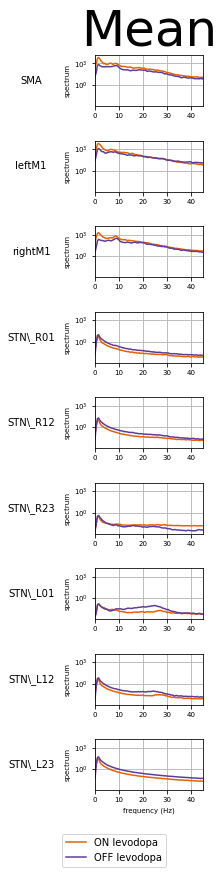

In [10]:
####################
# plot the results #
####################

# plot the linear spectral density
psd_fig = plt.figure(figsize=(3, 11.7))
psd_gs = mpl.gridspec.GridSpec(n_ch + 1,2, width_ratios=(0.1,1))
psd_axes = np.zeros(n_ch, dtype=np.object)
text_axes = np.zeros(n_ch, dtype=np.object)
psd_lines = np.zeros((n_ch, 2), dtype=np.object)
for i in range(n_ch):
    if i == 0:
        psd_axes[i] = psd_fig.add_subplot(psd_gs[i,1])
    else:
        psd_axes[i] = psd_fig.add_subplot(psd_gs[i,1],
                sharex=psd_axes[0], sharey=psd_axes[0])
    psd_axes[i].grid()
    psd_lines[i,0], = psd_axes[i].semilogy(on_f[on_f<=plot_f], np.abs(
        on_csd[i,i,on_f<=plot_f]), color=color1)
    psd_lines[i,1], = psd_axes[i].semilogy(off_f[off_f<=plot_f], np.abs(
        off_csd[i,i,off_f<=plot_f]), color=color2)
    psd_axes[i].set_ylabel('spectrum')
    text_axes[i] = psd_fig.add_subplot(psd_gs[i,0], frameon=False)
    text_axes[i].tick_params(**blind_ax)
    text_axes[i].text(0.5,0.5, s=on_labels[i].replace('_', '\_'),
            ha='center', va='center')

psd_axes[-1].set_xlabel('frequency (Hz)')
psd_axes[-1].set_xlim([0,plot_f])

# add a dummy axis for the legend
psd_legend_ax = psd_fig.add_subplot(psd_gs[-1,:], frame_on=False)
psd_legend_ax.tick_params(**blind_ax)
psd_legend_ax.legend((psd_lines[0,0], psd_lines[0,1]),
        ('ON levodopa', 'OFF levodopa'), loc='center')

psd_fig.tight_layout()
psd_axes[0].set_title("Mean", fontsize=50)
plt.show()

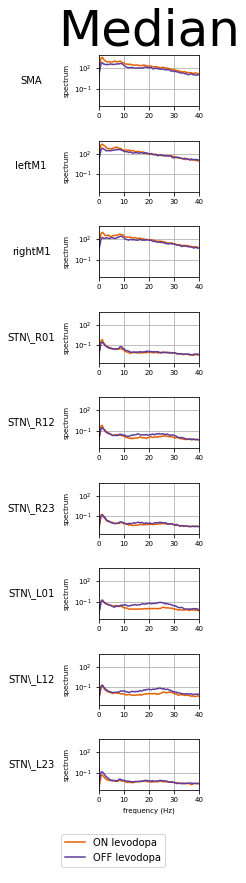

In [11]:
####################
# plot the results #
####################
#n_ch = on_data.shape[0] - 1 # the last channel is the event label
n_ch = 9 # plot only the first 9 channels
plot_f = 40 # frequency until which the signal is plotted

# plot the linear spectral density
psd_fig = plt.figure(figsize=(3, 11.7))
psd_gs = mpl.gridspec.GridSpec(n_ch + 1,2, width_ratios=(0.1,1))
psd_axes = np.zeros(n_ch, dtype=np.object)
text_axes = np.zeros(n_ch, dtype=np.object)
psd_lines = np.zeros((n_ch, 2), dtype=np.object)
for i in range(n_ch):
    if i == 0:
        psd_axes[i] = psd_fig.add_subplot(psd_gs[i,1])
    else:
        psd_axes[i] = psd_fig.add_subplot(psd_gs[i,1],
                sharex=psd_axes[0], sharey=psd_axes[0])
    psd_axes[i].grid()
    psd_lines[i,0], = psd_axes[i].semilogy(on_f_med[on_f_med<=plot_f], np.abs(
        on_csd_med[i,i,on_f_med<=plot_f]), color=color1)
    psd_lines[i,1], = psd_axes[i].semilogy(off_f_med[off_f_med<=plot_f], np.abs(
        off_csd_med[i,i,off_f_med<=plot_f]), color=color2)
    psd_axes[i].set_ylabel('spectrum')
    text_axes[i] = psd_fig.add_subplot(psd_gs[i,0], frameon=False)
    text_axes[i].tick_params(**blind_ax)
    text_axes[i].text(0.5,0.5, s=on_labels[i].replace('_', '\_'),
            ha='center', va='center')

psd_axes[-1].set_xlabel('frequency (Hz)')
psd_axes[-1].set_xlim([0,plot_f])

# add a dummy axis for the legend
psd_legend_ax = psd_fig.add_subplot(psd_gs[-1,:], frame_on=False)
psd_legend_ax.tick_params(**blind_ax)
psd_legend_ax.legend((psd_lines[0,0], psd_lines[0,1]),
        ('ON levodopa', 'OFF levodopa'), loc='center')

psd_fig.tight_layout()
psd_axes[0].set_title("Median", fontsize=50)
plt.show()
#psd_fig.savefig('subj1_psd.pdf')
